In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, h5py #table
import pandas as pd, matplotlib.pyplot  as plt, numpy as np
import matplotlib.ticker as tck
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
from scipy import stats
import seaborn as sns

sys.path.append('..')
from utilities import model_src as s
from utilities.model import *
from utilities.model_prep import *

ModuleNotFoundError: No module named 'seaborn'

In [2]:
folder = '/Users/barberwalters/Geoffrey_Work/Repo/nwrfc-auto-calibration'
#folder='/home/gwalters/Repo/nwrfc-auto-calibration'

In [5]:
def nse(predictions, targets):
    return 1-np.sum((targets-predictions)**2)/np.sum((targets-targets.mean())**2)

def nnse(predictions, targets):
    return 1/(2-nse(predictions, targets))

def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).sum())/np.sqrt(((targets - targets.mean()) ** 2).sum())

def pbias(predictions, targets):
    return 100*(predictions-targets).sum()/targets.sum()

def pbias_norm(predictions, targets):
    return 1-abs(pbias(predictions, targets))/100

def rsquared(predictions, targets):       
    slope, intercept, r_value, p_value, std_err = stats.linregress(targets,predictions)
    return r_value**2

def sdr(predictions, targets):
    return 1-abs(predictions.std()/targets.std()-1)

def f(x):
    d = {}
    #d['nse'] = nse(x.sim_flow_cfs, x.flow_cfs)
    d['nnse'] = nnse(x.sim_flow_cfs, x.flow_cfs)
    #d['sdr'] = sdr(x.sim_flow_cfs, x.flow_cfs)
    d['rsquared'] = rsquared(x.sim_flow_cfs, x.flow_cfs)
    d['pbias_norm'] = pbias_norm(x.sim_flow_cfs, x.flow_cfs)
    #d['combo']=d['pbias_norm']+d['nnse']
    return pd.Series(d, index=['rsquared','nnse','pbias_norm'])
    #return pd.Series(d, index=['nse','nnse','sdr' ,'pbias','pbias_norm','combo'])

In [6]:
#Grabs the DataRanger results for a USGS site and format for HDF5
def format_dr(data_ranger_df,usgs_num):
    
    sf_ts=data_ranger_df.loc[int(usgs_num),:].copy()
    sf_ts['Source'] = np.where(sf_ts.imputed, 'Data_Ranger','USGS_'+str(usgs_num))
    sf_ts['datetime']=pd.to_datetime(sf_ts['datetime'])
    sf_ts.rename(columns={'value':'Daily_Avg_Streamflow_cfs','datetime':'date_local_tz'},inplace=True)
    sf_ts.reset_index(inplace=True)
    sf_ts.set_index('date_local_tz',inplace=True)
    sf_ts=sf_ts.loc['1979':'2019',:]
    
    #Check if the first two value in the DR file are errounously imputed
    #source=sf_ts.loc['1979-01-03',['Source']]   
    #if source.str.contains('USGS').values.squeeze():
    #    sf_ts.loc[:'1979-01-02',['Source']]=source.values[0]
    #    usgs_num=source.values[0].split('_')[-1]
    #    og_sf=pd.read_csv(os.path.join(folder,'USGS_Daily_Streamflow',usgs_num+'_daily_cfs.csv'),index_col='datetimeUTC',parse_dates=True)
    #    sf_ts.loc[:'1979-01-02',['Daily_Avg_Streamflow_cfs']]=og_sf.loc[:'1979-01-02',['Daily_Avg_Streamflow_cfs']].values
    
    return sf_ts.loc[:,['Daily_Avg_Streamflow_cfs','Source']]

def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

def hdf_to_df(hdf5, path):

    df=pd.DataFrame(hdf5[path][:])
    date_time=df.columns[0]
    df[date_time]=pd.to_datetime(df[date_time].str.decode('utf-8'))
    df['Source']=df['Source'].str.decode('utf-8')
    df.set_index(date_time,inplace=True)
    return df

def df_to_sarray(df):
    """
    Convert a pandas DataFrame object to a numpy structured array.
    Also, for every column of a str type, convert it into 
    a 'bytes' str literal of length = max(len(col)).

    :param df: the data frame to convert
    :return: a numpy structured array representation of df
    """

    def make_col_type(col_type, col):
        try:
            if 'numpy.object_' in str(col_type.type):
                maxlens = col.dropna().str.len()
                if maxlens.any():
                    maxlen = int(maxlens.max()) 
                    col_type = ('S%s' % maxlen)
                else:
                    col_type = 'f2'
            return col.name, col_type
        except:
            print(col.name, col_type, col_type.type, type(col))
            raise

    v = df.values            
    types = df.dtypes
    numpy_struct_types = [make_col_type(types[col], df.loc[:, col]) for col in df.columns]
    dtype = np.dtype(numpy_struct_types)
    z = np.zeros(v.shape[0], dtype)
    for (i, k) in enumerate(z.dtype.names):
        # This is in case you have problems with the encoding, remove the if branch if not
        try:
            if dtype[i].str.startswith('|S'):
                z[k] = df[k].str.encode('latin').astype('S')
            else:
                z[k] = v[:, i]
        except:
            print(k, v[:, i])
            raise

    return z, dtype

In [9]:
#Extact files from calibration folder

analysis_files=pd.DataFrame(columns=['Path','File','Run','LID']) 
n=1

for root, dirs, files in os.walk(os.path.join(folder,'runs','cluster10-rerun-best-only')):
    for file in files:
        if ('optimal_daily' in file or 'pars_optimal' in file or 'optimal_states_6h' in file):# and 'por' in root.split('\\')[-1]:
             analysis_files=pd.concat([analysis_files,
                                      pd.DataFrame({'Path':root,
                                                    'File':file,
                                                    'Run':root.split('/')[-1],
                                                    'LID':root.split('/')[-2]},
                                                   index=[n])],axis=0)

             n=n+1
            
#analysis_files['Best_Run']= analysis_files.Path.str.split('\\').str[-2].str.contains('best')
#analysis_files.loc[analysis_files.Best_Run,['LID']]=analysis_files.loc[analysis_files.Best_Run].Path.str.split('\\').str[-3]

legacy_files=pd.DataFrame(columns=['Path','File','LID']) 
#n=1

for root, dirs, files in os.walk(os.path.join(folder,'data','Legacy_Historical_Simulated','Legacy_Historical_Simulated')):
    for file in files:
        if ('SQIN' in file):
             legacy_files=pd.concat([legacy_files,
                                      pd.DataFrame({'Path':root,
                                                    'File':file,
                                                   'LID':file.split('_')[0]},
                                                   index=[n])],axis=0)

             n=n+1 

In [10]:
#CV analysis, CV vs POR 

cv_stats_master_df=pd.DataFrame()
por_stats_master_df=pd.DataFrame()
degrade_master_por_df=pd.DataFrame()

for lid in analysis_files.LID.unique():
    
    #best_por_file=analysis_files.loc[(analysis_files.LID==lid)&(analysis_files.Best_Run==True)&
    #               (analysis_files.Run.str.contains('por'))&(analysis_files.File.str.contains('optimal_daily'))]
    best_por_file=analysis_files.loc[(analysis_files.LID==lid)&
                   (analysis_files.Run.str.contains('por'))&(analysis_files.File.str.contains('optimal_daily'))]
    best_por_sf=pd.read_csv(os.path.join(best_por_file.Path.squeeze(),best_por_file.File.squeeze()))
    best_por_sf.index=pd.to_datetime(best_por_sf[['year','month','day']])
    

    best_cv_files=analysis_files.loc[(analysis_files.LID==lid)&
                   (analysis_files.Run.str.contains('cv'))&(analysis_files.File.str.contains('optimal_daily'))]
    #best_cv_files=analysis_files.loc[(analysis_files.LID==lid)&(analysis_files.Best_Run==True)&
    #               (analysis_files.Run.str.contains('cv'))&(analysis_files.File.str.contains('optimal_daily'))]

    for index, row in best_cv_files.iterrows():

        best_cv_sf=pd.read_csv(os.path.join(row.Path,'validation_daily.csv'))
        best_cv_sf.index=pd.to_datetime(best_cv_sf[['year','month','day']])
        #Necessary to remove the warm up year from CV1,doesn't affect other folds
        best_cv_sf=best_cv_sf.loc['Oct 1980':]
        
        best_por_sf_cv=best_por_sf.loc[best_cv_sf.index]
        
        cv_all_stats=f(best_cv_sf)
        por_all_stats=f(best_por_sf_cv)
        all_degrade=cv_all_stats-por_all_stats
        
        hf_th=best_cv_sf.flow_cfs.quantile(.95)

        best_cv_hf=best_cv_sf.loc[best_cv_sf.flow_cfs>=hf_th]
        best_por_hf=best_por_sf.loc[best_por_sf.flow_cfs>=hf_th]
          
        cv_hf_stats=f(best_cv_hf)
        por_hf_stats=f(best_por_hf)
        hf_degrade=cv_hf_stats-por_hf_stats
        
        best_cv_jjws=best_cv_sf.loc[best_cv_sf.index.month<=7].resample('A-SEP').sum()
        best_cv_asws=best_cv_sf.loc[(best_cv_sf.index.month>=4)&(best_cv_sf.index.month<=9)].resample('A-SEP').sum()

        best_por_jjws=best_por_sf_cv.loc[best_por_sf_cv.index.month<=7].resample('A-SEP').sum()
        best_por_asws=best_por_sf_cv.loc[(best_por_sf_cv.index.month>=4)&(best_por_sf_cv.index.month<=9)].resample('A-SEP').sum()

        cv_jjws_stats=f(best_cv_jjws)
        por_jjws_stats=f(best_por_jjws)
        jjws_degrade=cv_jjws_stats-por_jjws_stats

        cv_asws_stats=f(best_cv_asws)
        por_asws_stats=f(best_por_asws)
        asws_degrade=cv_asws_stats-por_asws_stats

        cv_mthly_stats=best_cv_sf.groupby(best_cv_sf.index.month).apply(f)
        cv_mthly_stats=cv_mthly_stats.sum().divide(12)
        
        por_mthly_stats=best_por_sf_cv.groupby(best_por_sf_cv.index.month).apply(f)
        por_mthly_stats=por_mthly_stats.sum().divide(12)
        
        mthly_degrade=cv_mthly_stats-por_mthly_stats
        
        cv_stats_df=pd.DataFrame({'All Daily':cv_all_stats,'Monthly Binned':cv_mthly_stats,
              'Q>.95 \n Highflows':cv_hf_stats,'Period Volume \n Jan-Jul':cv_jjws_stats,'Period Volume \n Apr-Sep':cv_asws_stats,
             'LID':lid,'Fold':'-'.join(row.Run.split('_')[1:-1]),'Period':'Validation'})
        cv_stats_df.reset_index(inplace=True)
        cv_stats_df.rename(columns={'index': 'metric' },inplace=True)       
        cv_stats_master_df=pd.concat([cv_stats_master_df,cv_stats_df],
                                     axis=0, ignore_index=True)
        
        por_stats_df=pd.DataFrame({'All Daily':por_all_stats,'Monthly Binned':por_mthly_stats,
              'Q>.95 \n Highflows':por_hf_stats,'Period Volume \n Jan-Jul':por_jjws_stats,'Period Volume \n Apr-Sep':por_asws_stats,
             'LID':lid,'Fold':'-'.join(row.Run.split('_')[1:-1]),'Period':'POR_Run'})
        por_stats_df.reset_index(inplace=True)
        por_stats_df.rename(columns={'index': 'metric' },inplace=True)       
        por_stats_master_df=pd.concat([por_stats_master_df,por_stats_df],
                                     axis=0, ignore_index=True)
        
        degrade_df=pd.DataFrame({'All Daily':all_degrade,'Monthly Binned':mthly_degrade,
              'Q>.95 \n Highflows':hf_degrade,'Period Volume \n Jan-Jul':jjws_degrade,'Period Volume \n Apr-Sep':asws_degrade,
             'LID':lid,'Fold':'-'.join(row.Run.split('_')[1:-1]),'Period':'Vs \n POR Run'})
        degrade_df.reset_index(inplace=True)
        degrade_df.rename(columns={'index': 'metric' },inplace=True)       
        degrade_master_por_df=pd.concat([degrade_master_por_df,degrade_df],
                                     axis=0, ignore_index=True)

#cv_stats_master_df.to_csv('cv_stats-All.csv',index=False)
#por_stats_master_df.to_csv('por_stats-All.csv',index=False)

In [9]:
#####NOT BEING USED############
####CONSIDER ERASING#####
#CV analysis, CV vs POR 

for lid in degrade_master_por_df.LID.unique():
#lid='NASW1'
    cv_plot_df=pd.DataFrame(degrade_master_por_df.loc[(degrade_master_por_df.LID==lid)].drop(['LID'], axis=1).set_index(['Period','Fold','metric']).stack())
    cv_plot_df.reset_index(inplace=True)
    cv_plot_df.sort_values(by=['metric','Fold','level_3'], key=lambda col: col.str.lower(),inplace=True)

    sns.set_style("whitegrid")
    g = sns.catplot(
        data=cv_plot_df, kind="swarm",
        x='Period', y=0, hue="Fold", col='level_3',row='metric',
        aspect=.5)

    ax = g.axes.flatten()

    g.map(plt.axhline, y=-0.1, ls='--', color='r', linewidth=2)
    g.map(plt.axhline, y=0, lw=2, ls='--',color='black', linewidth=2)
    y_axis_lim=ax[0].get_ylim()
    g.map(plt.axhspan, ymin=y_axis_lim[0] ,ymax=-0.1, color='gray', alpha=.5)
    g.set(ylim=y_axis_lim)
    g.set_titles("{col_name}") 
    g.set_axis_labels(y_var=r'Metric Change ($\Delta$)')
    g.set(xticklabels=[])
    g.set(xlabel=None)
    g.fig.suptitle(lid,y=1.05,fontsize=20)

    #plt.rc('text', usetex=True)

    ax[0].text(0.05, 1.065,'NNSE', fontsize=18,color='r',transform=ax[0].transAxes) 
    ax[0].text(1.53, 1.175,'(Valid period performance score - POR run performance score)', fontsize=12,transform=ax[0].transAxes)
    ax[5].text(0.05, 1.065,'Pbias', fontsize=18,color='g',transform=ax[5].transAxes) 
    ax[10].text(0.05, 1.065,'R2', fontsize=18,color='b',transform=ax[10].transAxes)

    if not os.path.isdir('CV_Performance_Plots'):
        os.mkdir('CV_Performance_Plots')
    if not os.path.isdir(os.path.join('CV_Performance_Plots','versus_POR_Run' )):
        os.mkdir(os.path.join('CV_Performance_Plots','versus_POR_Run' ))
        
    g.savefig(os.path.join('CV_Performance_Plots','versus_POR_Run',lid+'.png'),bbox_inches = "tight")
    plt.clf()
    plt.close('all')

In [11]:
#CV analysis, valid vs calb period 

cv_stats_master_df=pd.DataFrame()
por_stats_master_df=pd.DataFrame()
degrade_master_calb_df=pd.DataFrame()

for lid in analysis_files.LID.unique():

    
    best_cv_files=analysis_files.loc[(analysis_files.LID==lid)&
                   (analysis_files.Run.str.contains('cv'))&(analysis_files.File.str.contains('optimal_daily'))]
    
    #best_cv_files=analysis_files.loc[(analysis_files.LID==lid)&(analysis_files.Best_Run==True)&
    #               (analysis_files.Run.str.contains('cv'))&(analysis_files.File.str.contains('optimal_daily'))]
    
    for index, row in best_cv_files.iterrows():

        best_cv_sf_valid=pd.read_csv(os.path.join(row.Path,'validation_daily.csv'))
        best_cv_sf_valid.index=pd.to_datetime(best_cv_sf_valid[['year','month','day']])
        #Necessary to remove the warm up year from CV1,doesn't affect other folds
        best_cv_sf_valid=best_cv_sf_valid.loc['Oct 1980':]
        
        best_cv_sf_calb=pd.read_csv(os.path.join(row.Path,'optimal_daily.csv'))
        best_cv_sf_calb.index=pd.to_datetime(best_cv_sf_calb[['year','month','day']])
        #Necessary to remove the warm up year from CV2-4,doesn't affect CV1
        best_cv_sf_calb=best_cv_sf_calb.loc['Oct 1980':]
        
        cv_all_stats=f(best_cv_sf_valid)
        por_all_stats=f(best_cv_sf_calb)
        all_degrade=cv_all_stats-por_all_stats
        
        hf_th=best_cv_sf_valid.flow_cfs.quantile(.95)

        best_cv_hf=best_cv_sf_valid.loc[best_cv_sf_valid.flow_cfs>=hf_th]
        best_por_hf=best_cv_sf_calb.loc[best_cv_sf_calb.flow_cfs>=hf_th]
          
        cv_hf_stats=f(best_cv_hf)
        por_hf_stats=f(best_por_hf)
        hf_degrade=cv_hf_stats-por_hf_stats
        
        best_cv_jjws=best_cv_sf_valid.loc[best_cv_sf_valid.index.month<=7].resample('A-SEP').sum()
        best_cv_asws=best_cv_sf_valid.loc[(best_cv_sf_valid.index.month>=4)&(best_cv_sf_valid.index.month<=9)].resample('A-SEP').sum()

        best_por_jjws=best_cv_sf_calb.loc[best_cv_sf_calb.index.month<=7].resample('A-SEP').sum()
        best_por_asws=best_cv_sf_calb.loc[(best_cv_sf_calb.index.month>=4)&(best_cv_sf_calb.index.month<=9)].resample('A-SEP').sum()

        cv_jjws_stats=f(best_cv_jjws)
        por_jjws_stats=f(best_por_jjws)
        jjws_degrade=cv_jjws_stats-por_jjws_stats

        cv_asws_stats=f(best_cv_asws)
        por_asws_stats=f(best_por_asws)
        asws_degrade=cv_asws_stats-por_asws_stats

        cv_mthly_stats=best_cv_sf_valid.groupby(best_cv_sf_valid.index.month).apply(f)
        cv_mthly_stats=cv_mthly_stats.sum().divide(12)
        
        por_mthly_stats=best_cv_sf_calb.groupby(best_cv_sf_calb.index.month).apply(f)
        por_mthly_stats=por_mthly_stats.sum().divide(12)
        
        mthly_degrade=cv_mthly_stats-por_mthly_stats
        
        cv_stats_df=pd.DataFrame({'All Daily':cv_all_stats,'Monthly Binned':cv_mthly_stats,
              'Q>.95 \n Highflows':cv_hf_stats,'Period Volume \n Jan-Jul':cv_jjws_stats,'Period Volume \n Apr-Sep':cv_asws_stats,
             'LID':lid,'Fold':'-'.join(row.Run.split('_')[1:-1]),'Period':'Validation'})
        cv_stats_df.reset_index(inplace=True)
        cv_stats_df.rename(columns={'index': 'metric' },inplace=True)       
        cv_stats_master_df=pd.concat([cv_stats_master_df,cv_stats_df],
                                     axis=0, ignore_index=True)
        
        
        por_stats_df=pd.DataFrame({'All Daily':por_all_stats,'Monthly Binned':por_mthly_stats,
              'Q>.95 \n Highflows':por_hf_stats,'Period Volume \n Jan-Jul':por_jjws_stats,'Period Volume \n Apr-Sep':por_asws_stats,
             'LID':lid,'Fold':'-'.join(row.Run.split('_')[1:-1]),'Period':'Calibration'})
        por_stats_df.reset_index(inplace=True)
        por_stats_df.rename(columns={'index': 'metric' },inplace=True)       
        por_stats_master_df=pd.concat([por_stats_master_df,por_stats_df],
                                     axis=0, ignore_index=True)
        
        degrade_df=pd.DataFrame({'All Daily':all_degrade,'Monthly Binned':mthly_degrade,
              'Q>.95 \n Highflows':hf_degrade,'Period Volume \n Jan-Jul':jjws_degrade,'Period Volume \n Apr-Sep':asws_degrade,
             'LID':lid,'Fold':'-'.join(row.Run.split('_')[1:-1]),'Period':'Vs \n Calb Period'})
        degrade_df.reset_index(inplace=True)
        degrade_df.rename(columns={'index': 'metric' },inplace=True)       
        degrade_master_calb_df=pd.concat([degrade_master_calb_df,degrade_df],
                                     axis=0, ignore_index=True)
     
        
#cv_stats_master_df.to_csv('cv_stats-All.csv',index=False)
#por_stats_master_df.to_csv('por_stats-All.csv',index=False)

In [12]:
#CV analysis

degrade_master_df=pd.concat([degrade_master_calb_df,degrade_master_por_df],axis=0)

for lid in degrade_master_df.LID.unique():
#lid='NASW1'
    cv_plot_df=pd.DataFrame(degrade_master_df.loc[(degrade_master_df.LID==lid)].drop(['LID'], axis=1).set_index(['Period','Fold','metric']).stack())
    cv_plot_df.reset_index(inplace=True)
    cv_plot_df.sort_values(by=['metric','Fold','level_3'], key=lambda col: col.str.lower(),inplace=True)

    sns.set_style("whitegrid")
    g = sns.catplot(
        data=cv_plot_df, kind="swarm",
        x='Period', y=0, hue="Fold", col='level_3',row='metric',
        aspect=.5, sharex=False)

    ax = g.axes.flatten()

    g.map(plt.axhline, y=-0.1, ls='--', color='r', linewidth=2)
    g.map(plt.axhline, y=0, lw=2, ls='--',color='black', linewidth=2)
    y_axis_lim=ax[0].get_ylim()
    g.map(plt.axhspan, ymin=y_axis_lim[0] ,ymax=-0.1, color='gray', alpha=.5)
    g.set(ylim=y_axis_lim)
    g.set_titles("{col_name}") 
    g.set_axis_labels(y_var=r'Metric Change ($\Delta$)')
    #g.set(xticklabels=[])
    #g.set(xlabel=None)
    g.fig.suptitle(lid,y=1.05,fontsize=20)


    ax[0].text(0.015, 1.065,'NNSE', fontsize=18,color='r',transform=ax[0].transAxes) 
    ax[0].text(1.35, 1.18,'(Valid period performance score - POR run or calb period performance score)', fontsize=12,transform=ax[0].transAxes)
    ax[5].text(0.015, 1.065,'Pbias', fontsize=18,color='g',transform=ax[5].transAxes) 
    ax[10].text(0.015, 1.065,'R2', fontsize=18,color='b',transform=ax[10].transAxes)

    if not os.path.isdir('CV_Performance_Plots'):
        os.mkdir('CV_Performance_Plots')

    g.savefig(os.path.join('CV_Performance_Plots',lid+'_CV_Plot.png'),bbox_inches = "tight")
    plt.clf()
    plt.close('all')

In [11]:
#OLD, CONSIDER ERASING!!
#CV analysis, valid vs calb period 

for org, plot_folder in zip([['Fold','LID'],['LID','Fold']],['Organized_by_Fold','Organized_by_LID']):
    for stat in ['nnse', 'pbias_norm', 'rsquared','combo']:

        #CV analysis, valid vs calb period
        metric=stat #'nnse' 'pbias_norm', 'combo'
        group=org[0]#'LID''Fold'
        drop=org[1]#'Fold' 'LID'
        y_axis_label='_Degradation (Valid-Calb Period)'

        degradation_plot_df=pd.DataFrame({metric+y_axis_label:degrade_master_df.loc[degrade_master_df.metric==metric].drop([drop,'metric'], axis=1).set_index([group]).stack()})
        degradation_plot_df.reset_index(inplace=True)
        degradation_plot_df.sort_values(by=[group,'level_1'], key=lambda col: col.str.lower(),inplace=True)
        
        fig, ax = plt.subplots(1,1, dpi= 80, facecolor='w',figsize=(10, 10))

        sns.boxplot(x='level_1', y=metric+y_axis_label,
                        hue=group,
                        data=degradation_plot_df, ax=ax)

        ax.grid()
        
        if not os.path.isdir('CV_Performance_Plots'):
            os.mkdir('CV_Performance_Plots')
        if not os.path.isdir(os.path.join('CV_Performance_Plots','versus_CV_Calb_Period' )):
            os.mkdir(os.path.join('CV_Performance_Plots','versus_CV_Calb_Period' ))
        if not os.path.isdir(os.path.join('CV_Performance_Plots','versus_CV_Calb_Period',plot_folder)):
            os.mkdir(os.path.join('CV_Performance_Plots','versus_CV_Calb_Period',plot_folder))
        
        fig.savefig(os.path.join('CV_Performance_Plots','versus_CV_Calb_Period',plot_folder,metric+'.png'),bbox_inches = "tight")
        plt.clf()
        plt.close('all')

Text(0.5, 0, 'Date')

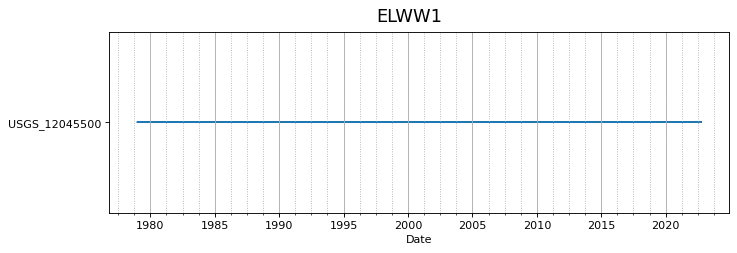

In [16]:
#Flow Data Source Plot


#for lid in analysis_files.LID.unique():
lid= 'ELWW1'
store=h5py.File(os.path.join(folder,'data','HDF5_Files',lid+'.h5'), 'r')
keys=pd.Series(get_dataset_keys(store))
flow_keys=keys.loc[keys.str.contains('Daily')&keys.str.contains('Streamflow')].sort_values()
num_subplots=len(flow_keys)


fig, axs = plt.subplots(num_subplots,1, sharex=True, dpi= 80, facecolor='w',figsize=(10, num_subplots*3))

for i, ax in enumerate(fig.axes): 
    
    flow=hdf_to_df(store, flow_keys.iloc[i])
    
    # List of RGB triplets
    rgb_values = sns.color_palette("tab10", 8)
    # Map label to RGB
    color_map = dict(zip(flow.Source.unique(), rgb_values))
    ax.scatter(flow.index,flow.Source,marker='.',c=flow['Source'].map(color_map),s=.5)

    ax.grid(which='major', axis='x')
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.grid(which='minor', axis='x',linestyle=':')
    
    if 'Tributary' in flow_keys.iloc[i]:
        sub_title='Tributary:  '+flow_keys.iloc[i].split('/')[-2]
        ax.set_title(sub_title)
    
store.close

fig.suptitle(lid, fontsize=16)
ax.set_xlabel('Date')

#fig.savefig(lid+'_flow_data_sources.png',bbox_inches = "tight")

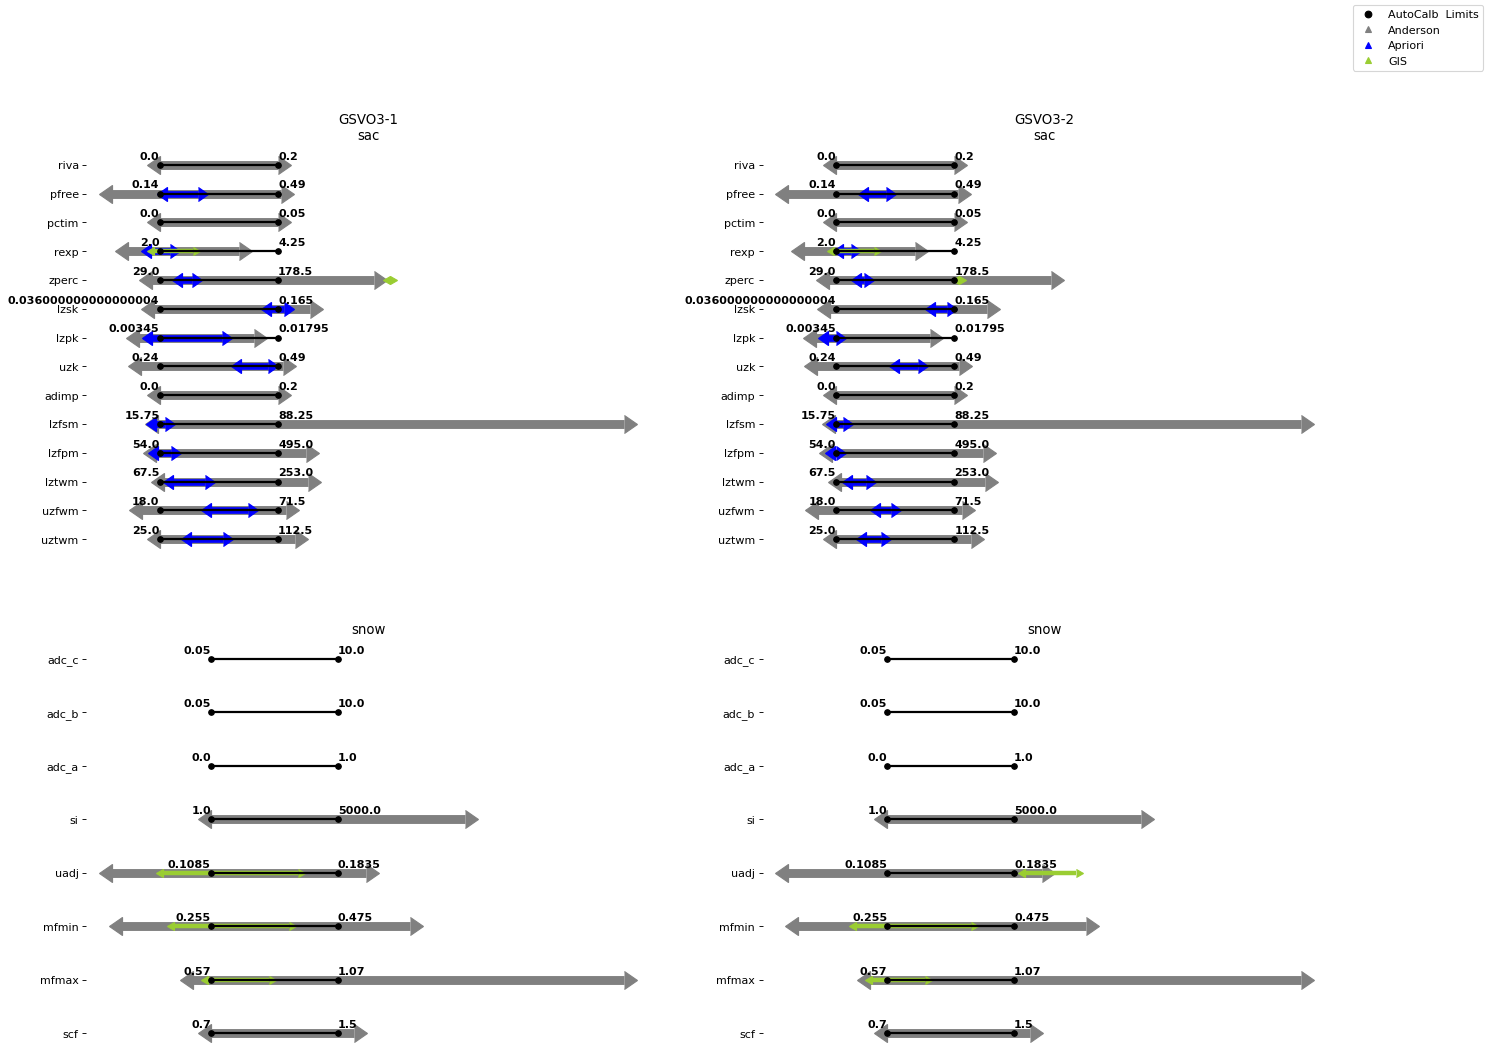

In [6]:
lid='GSVO3'
path=analysis_files.loc[analysis_files.LID==lid].Path.str.split('/').str[:-1].str.join('/').unique()[0]
#path=analysis_files.Path.str.split('/').str[:-1].str.join('/').unique()[0]

ac_limits=pd.read_csv(os.path.join(path,'pars_limits.csv'),index_col='name')
ac_defaults=pd.read_csv(os.path.join(path,'pars_default.csv'))
ac_defaults['parameters']=ac_defaults['name']
ac_defaults['name']=ac_defaults['name']+'_'+ac_defaults['zone']
ac_defaults=ac_defaults.loc[:,~ac_defaults.columns.str.contains('zone')]
ac_limits=ac_limits.merge(ac_defaults, how='left',on='name')

ref_param=pd.read_csv(os.path.join(path,'param_reference_ranges.csv'))

zones=ac_limits.loc[ac_limits.zone.str.contains('-')].zone.unique()
i=0
fig, axes = plt.subplots(2,len(zones), dpi= 80, facecolor='w',figsize=(10*len(zones),15))
for type in ['sac','snow']:
    for zone in zones:
        
        ax=fig.axes[i]
        
        param_df=ac_limits.loc[(ac_limits.type==type)&(ac_limits.zone==zone)]

        for index, row in param_df.iterrows():
            param_plot_df=pd.DataFrame({'limits':[row.lower,row.upper],'parameter':row.parameters})
            ax.plot(param_plot_df.index,param_plot_df.parameter,color='black',marker='o',markersize=5,lw=2,zorder=5)
            ax.annotate(row.lower,[0,row.parameters],xytext=(0, 5), textcoords='offset points',ha='right',zorder=6, weight='bold')
            ax.annotate(row.upper,[1,row.parameters],xytext=(0, 5), textcoords='offset points',zorder=6, weight='bold')

            ref_df=ref_param.loc[(ref_param.param==row.parameters)&(ref_param.zone==zone)].copy()
            ref_df['min_norm']=(ref_df.loc[:,'min'].subtract(param_plot_df.limits[0]))/param_plot_df.limits.diff()[1]
            ref_df['max_norm']=(ref_df['max']-param_plot_df.limits[0])/param_plot_df.limits.diff()[1]
            ref_df['min_norm_plt']=0
            ref_df['max_norm_plt']=ref_df.max_norm-ref_df.min_norm

            for index2, row2 in ref_df.iterrows():

                if row2.type == 'anderson' : 
                    err_color = 'grey' 
                    lwidth=8
                    zo=2
                elif row2.type == 'apriori' : 
                    err_color = 'blue'
                    lwidth=6
                    zo=3
                else: 
                    err_color = 'yellowgreen'
                    lwidth=4
                    zo=4

                ax.errorbar(row2.min_norm,row2.param,xerr=pd.DataFrame(row2.loc[['min_norm_plt']]), 
                               capsize=lwidth,color=err_color,xuplims=True,zorder=zo)
                line=ax.errorbar(row2.min_norm,row2.param,xerr=pd.DataFrame(row2.loc[['max_norm_plt']]), 
                               capsize=lwidth,color=err_color,xlolims=True,zorder=zo)

                line[-1][0].set_linewidth(lwidth) 
                #line[-1][0].set_linestyle(':')


        #ax.set_xlim([-.25,1.25])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        if i < len(zones):  ax.set_title(zone +'\n'+type)
        else:  ax.set_title(type)
        i+=1

legend_elements = [Line2D([0], [0], marker='o', color='black', linestyle='None', label='AutoCalb  Limits'),
                   Line2D([0], [0], marker='^', color='grey', linestyle='None', label='Anderson'),
                   Line2D([0], [0], marker='^', color='blue', linestyle='None', label='Apriori'),
                   Line2D([0], [0], marker='^', color='yellowgreen', linestyle='None', label='GIS')]
fig.legend(handles=legend_elements)

fig.savefig(lid+'_parameter_limits.png',bbox_inches = "tight")

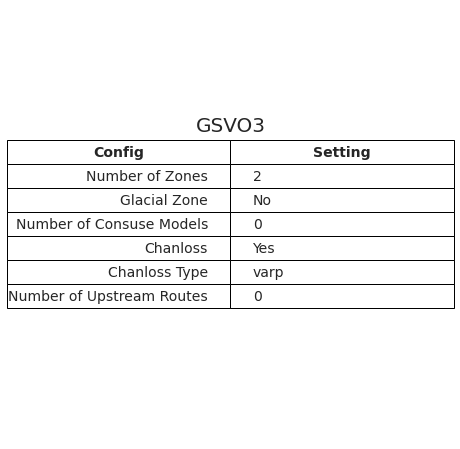

In [11]:
lid='GSVO3'
path=analysis_files.loc[analysis_files.LID==lid].Path.unique()[0]
pars=pd.read_csv(os.path.join(path,'pars_optimal.csv'))

num_zones=len(pars.loc[(~pars.zone.str.contains('_CU'))&
                  (~pars.zone.str.contains('-G'))&
                  (pars.zone.str.contains('-'))].zone.unique())
num_cu_zones=len(pars.loc[(pars.zone.str.contains('_CU'))].zone.unique())
if len(pars.loc[(pars.zone.str.contains('-G'))].zone.unique())>0:
       glacial_zone='Yes'
else: glacial_zone='No'
    
if pars.loc[pars.name=='n_clmods','value'].squeeze()>0:
    cl='Yes'
    if pars.loc[pars.name=='cl_type','value'].squeeze()==1:
            cl_type='varp'
    else:
        cl_type='varq'
else: 
    cl='No'
    cl_type=np.nan

num_routes=len(pars.loc[(pars.type.str.contains('lagk'))].zone.unique())

config_table=pd.DataFrame({
    'Config':['Number of Zones','Glacial Zone','Number of Consuse Models','Chanloss','Chanloss Type','Number of Upstream Routes'],
    'Setting':[num_zones,glacial_zone,num_cu_zones,cl,cl_type,num_routes]})
#config_table.set_index('Config',inplace=True)

fig, ax =plt.subplots(figsize=(8,8))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=config_table.values,colLabels=config_table.columns,loc='center')

the_table.auto_set_font_size(False)
the_table.scale(1, 2)
for (row, col), cell in the_table.get_celld().items():
    if (row == 0):
        cell.set_text_props(fontproperties=FontProperties(weight='bold'),ha="center",fontsize=14)
    elif(row != 0)&(col == 0):
        cell.set_text_props(ha="right",fontsize=14)
    elif(row != 0)&(col == 1):
        cell.set_text_props(ha="left",fontsize=14)
ax.set_title(lid,x=.5,y=.7,fontsize=20)
fig.savefig(lid+'_autocalb_configuration.png')

In [135]:
master_combo_df=pd.DataFrame()

for index, row in autocalb_files.iterrows():


    autocalb_sim=pd.read_csv(os.path.join(row.Path,row.File))
    autocalb_sim.index=pd.to_datetime(autocalb_sim[['year','month','day']])
    
    legacy_LID=legacy_files.loc[legacy_files.LID.str.contains(row.LID)].LID.values[0]
    
    legacy_sim=pd.read_csv(os.path.join(folder,'Legacy_Historical_Simulated',legacy_LID+'_SQIN_HS_export.csv'),skiprows=[1],index_col='LocalStandardTime',parse_dates=True)
    legacy_sim=legacy_sim.resample('1D').mean()
    legacy_sim.columns=['sim_flow_cfs']
    legacy_sim=pd.concat([legacy_sim,autocalb_sim.flow_cfs],axis=1)

    autocalb_sim=autocalb_sim.loc['Oct 1980':]
    legacy_sim=legacy_sim.loc['Oct 1980':]

    hf_th=autocalb_sim.flow_cfs.quantile(.95)

    autocalb_hf=autocalb_sim.loc[autocalb_sim.flow_cfs>=hf_th]
    autocalb_hf_stats=f(autocalb_hf)

    legacy_hf=legacy_sim.loc[legacy_sim.flow_cfs>=hf_th]
    legacy_hf_stats=f(legacy_hf)

    hf_stats=pd.concat([legacy_hf_stats,autocalb_hf_stats],axis=1)
    hf_stats.columns=['legacy','autocalb']
    hf_stats.to_csv(os.path.join(folder,'Autocalb_Report_Supplemental','Q.95',row.LID+'.csv'))
    
    autocalb_jjws=autocalb_sim.loc[autocalb_sim.index.month<=7].resample('A-SEP').sum()
    autocalb_jjws_stats=f(autocalb_jjws)
    autocalb_asws=autocalb_sim.loc[(autocalb_sim.index.month>=4)&(autocalb_sim.index.month<=9)].resample('A-SEP').sum()
    autocalb_asws_stats=f(autocalb_asws)

    legacy_jjws=legacy_sim.loc[legacy_sim.index.month<=7].resample('A-SEP').sum()
    legacy_jjws_stats=f(legacy_jjws)
    legacy_asws=legacy_sim.loc[(legacy_sim.index.month>=4)&(legacy_sim.index.month<=9)].resample('A-SEP').sum()
    legacy_asws_stats=f(legacy_jjws)

    ws_stats=pd.concat([legacy_jjws_stats,autocalb_jjws_stats,legacy_asws_stats,autocalb_asws_stats],axis=1)
    ws_stats.columns=['legacy_Jan-Jul','autocalb_Jan-Jul','legacy_Apr-Sep','autocalb_Apr-Sep']
    ws_stats.to_csv(os.path.join(folder,'Autocalb_Report_Supplemental','WaterSupply',row.LID+'.csv'))
    
    autocalb_combo=autocalb_sim.groupby(autocalb_sim.index.month).apply(f)
    autocalb_combo['combo']=autocalb_combo.nse+autocalb_combo.pbias_norm
    autocalb_comb=autocalb_combo.sum().combo
    
    legacy_combo=legacy_sim.groupby(legacy_sim.index.month).apply(f)
    legacy_combo['combo']=legacy_combo.nse+legacy_combo.pbias_norm
    legacy_comb=legacy_combo.sum().combo
    
    autocalb_combo=autocalb_sim.groupby(autocalb_sim.index.month).apply(f)
    autocalb_combo['combo']=autocalb_combo.nse+autocalb_combo.pbias_norm
    autocalb_comb=autocalb_combo.sum().combo

    legacy_combo=legacy_sim.groupby(legacy_sim.index.month).apply(f)
    legacy_combo['combo']=legacy_combo.nse+legacy_combo.pbias_norm
    legacy_comb=legacy_combo.sum().combo

    combo_df=pd.DataFrame({'Autocalb_combo':autocalb_comb,'Legacy_combo':legacy_comb},index=[row.LID])

    master_combo_df=pd.concat([master_combo_df,combo_df],axis=0)

master_combo_df.to_csv(os.path.join(folder,'Autocalb_Report_Supplemental','Combo_Metric.csv'))

In [6]:
cluster7=['ALRW1','CALW1','MCMW1','SILO3','SKOW1','SSUW1','TLMO3', 'TLRW1', 'WYDW1']

cluster7_areas={'ALRW1':77,'CALW1':130,'MCMW1':76,'SILO3':203,'SKOW1':57,'SSUW1':76,'TLMO3':161, 'TLRW1':19, 'WYDW1':41}

obs_folder='C:\\Users\\geoffrey.walters\\Documents\\AORC\\Observed_Streamflow\\'

rr_df=pd.DataFrame()
flow_df=pd.DataFrame()
precip_df=pd.DataFrame()

for lid in cluster7:

    store=pd.HDFStore(os.path.join(obs_folder,'HDF5_Files',lid+'.h5'))

    precip=store.get('/Forcing/Zones1/MAP')
    precip.index=pd.to_datetime(precip.index)
    #precip=precip.loc['1980':]
    #precip_decade=precip.resample('10AS').sum()
    precip_wy=precip.resample('A-SEP').sum()
    

    flow=store.get('/Streamflow/Daily')
    flow.index=pd.to_datetime(flow.index)
    #flow=flow.loc['1980':]
    area_ft2=cluster7_areas[lid]*5280**2
    flow['Daily_Avg_Streamflow_Inch']=flow.Daily_Avg_Streamflow_cfs.multiply(60*60*24).divide(area_ft2).multiply(12)
    #flow_decade=flow.resample('10AS').sum()
    flow_wy=flow.resample('A-SEP').sum()

    #rr_df=pd.concat([precip_decade.Zone1_Inch,flow_decade.Daily_Avg_Streamflow_Inch],axis=1)
    perc_diff_df=pd.concat([precip_wy.Zone1_Inch,flow_wy.Daily_Avg_Streamflow_Inch],axis=1)

    rr=perc_diff_df.Zone1_Inch/perc_diff_df.Daily_Avg_Streamflow_Inch
    
    rr_df[lid]=rr
    flow_df[lid]=perc_diff_df.Daily_Avg_Streamflow_Inch
    precip_df[lid]=perc_diff_df.Zone1_Inch

    tables.file._open_files.close_all()

rr_df=rr_df.loc['1980':'2019']

Closing remaining open files:C:\Users\geoffrey.walters\Documents\AORC\Observed_Streamflow\HDF5_Files\ALRW1.h5...done
Closing remaining open files:C:\Users\geoffrey.walters\Documents\AORC\Observed_Streamflow\HDF5_Files\CALW1.h5...done
Closing remaining open files:C:\Users\geoffrey.walters\Documents\AORC\Observed_Streamflow\HDF5_Files\MCMW1.h5...done
Closing remaining open files:C:\Users\geoffrey.walters\Documents\AORC\Observed_Streamflow\HDF5_Files\SILO3.h5...done
Closing remaining open files:C:\Users\geoffrey.walters\Documents\AORC\Observed_Streamflow\HDF5_Files\SKOW1.h5...done
Closing remaining open files:C:\Users\geoffrey.walters\Documents\AORC\Observed_Streamflow\HDF5_Files\SSUW1.h5...done
Closing remaining open files:C:\Users\geoffrey.walters\Documents\AORC\Observed_Streamflow\HDF5_Files\TLMO3.h5...done
Closing remaining open files:C:\Users\geoffrey.walters\Documents\AORC\Observed_Streamflow\HDF5_Files\TLRW1.h5...done
Closing remaining open files:C:\Users\geoffrey.walters\Documents

In [64]:
cluster7=['ALRW1','CALW1','MCMW1','SILO3','SKOW1','SSUW1','TLMO3', 'TLRW1', 'WYDW1']

cluster7_areas={'ALRW1':77,'CALW1':130,'MCMW1':76,'SILO3':203,'SKOW1':57,'SSUW1':76,'TLMO3':161, 'TLRW1':19, 'WYDW1':41}

zones_split={'zone1':.65,'zone2':.35}

petq_df=pd.DataFrame()

pet_path='C:\\Users\\geoffrey.walters\\Documents\\AORC\\AutoCalb\\autocalb_complete\\WYDW1\\best-cv-runs\\results_cv_4_08'
pet_calb=pd.read_csv(os.path.join(pet_path,'optimal_states_6h.csv'))
pet_calb.index=pd.to_datetime(pet_calb[['year','month','day','hour']])
pet_valid=pd.read_csv(os.path.join(pet_path,'validation_states_6h.csv'))
pet_valid.index=pd.to_datetime(pet_valid[['year','month','day','hour']])
pet=pd.concat([pet_calb,pet_valid],axis=0)
pet=pet.loc[~pet.index.duplicated(keep='first')]
pet.sort_index(axis=0,inplace=True)
pet['pet']=(pet.pet_1*zones_split['zone1']+pet.pet_2*zones_split['zone2'])*0.0393701
pet_wy=pet.resample('A-SEP').sum()

obs_folder='C:\\Users\\geoffrey.walters\\Documents\\AORC\\Observed_Streamflow\\'
store=pd.HDFStore(os.path.join(obs_folder,'HDF5_Files','WYDW1.h5'))
flow=store.get('/Streamflow/Daily')
flow.index=pd.to_datetime(flow.index)
flow=flow.loc['10/1979':]
area_ft2=cluster7_areas['WYDW1']*5280**2
flow['Daily_Avg_Streamflow_Inch']=flow.Daily_Avg_Streamflow_cfs.multiply(60*60*24).divide(area_ft2).multiply(12)
#flow_decade=flow.resample('10AS').sum()
flow_wy=flow.resample('A-SEP').sum()

#rr_df=pd.concat([precip_decade.Zone1_Inch,flow_decade.Daily_Avg_Streamflow_Inch],axis=1)
perc_diff_df=pd.concat([pet_wy.pet,flow_wy.Daily_Avg_Streamflow_Inch],axis=1)

rr=perc_diff_df.pet/perc_diff_df.Daily_Avg_Streamflow_Inch

petq_df['WYDW1']=rr

tables.file._open_files.close_all()

petq_df=petq_df.loc['1980':'2019']

Closing remaining open files:C:\Users\geoffrey.walters\Documents\AORC\Observed_Streamflow\HDF5_Files\WYDW1.h5...done


In [52]:
evaluate_df=analysis_files.loc[(~analysis_files.Best_Run)&(analysis_files.File=='optimal_daily.csv')&(analysis_files.Run.str.contains('cv'))]

master_combo_df=pd.DataFrame(columns=['Run','LID','q>.95','WS_JJ','WS_AS','Mthly_Binned'])
n=1
row=evaluate_df.iloc[0]
autocalb_sim=pd.read_csv(os.path.join(row.Path,'validation_daily.csv'))
autocalb_sim.index=pd.to_datetime(autocalb_sim[['year','month','day']])
begin_eval=autocalb_sim.index[0]+pd.DateOffset(years=1) 
autocalb_sim=autocalb_sim.loc[begin_eval:]

hf_th=autocalb_sim.flow_cfs.quantile(.95)

autocalb_hf=autocalb_sim.loc[autocalb_sim.flow_cfs>=hf_th]
autocalb_hf_stats=f(autocalb_hf)
autocalb_hf_stats['combo']=autocalb_hf_stats.nse+autocalb_hf_stats.pbias_norm

autocalb_jjws=autocalb_sim.loc[autocalb_sim.index.month<=7].resample('A-SEP').sum()
autocalb_jjws_stats=f(autocalb_jjws)
autocalb_jjws_stats['combo']=autocalb_jjws_stats.nse+autocalb_jjws_stats.pbias_norm
autocalb_asws=autocalb_sim.loc[(autocalb_sim.index.month>=4)&(autocalb_sim.index.month<=9)].resample('A-SEP').sum()
autocalb_asws_stats=f(autocalb_asws)
autocalb_asws_stats['combo']=autocalb_asws_stats.nse+autocalb_asws_stats.pbias_norm

autocalb_monthly=autocalb_sim.groupby(autocalb_sim.index.month).apply(f)
autocalb_monthly['combo']=autocalb_monthly.nse+autocalb_monthly.pbias_norm
autocalb_monthly=autocalb_monthly.sum()

master_combo_df.loc[n]=[row.Run,row.LID,autocalb_hf_stats.combo,autocalb_jjws_stats.combo,
                        autocalb_asws_stats.combo,autocalb_monthly.combo]

In [55]:
evaluate_df=analysis_files.loc[(~analysis_files.Best_Run)&(analysis_files.File=='optimal_daily.csv')]

master_combo_df=pd.DataFrame(columns=['Run','LID','q>.95','WS_JJ','WS_AS','Mthly_Binned'])
n=1
for index, row in evaluate_df.iterrows():

    if 'por' in row.Run:
        autocalb_sim=pd.read_csv(os.path.join(row.Path,row.File))

    else:
        autocalb_sim=pd.read_csv(os.path.join(row.Path,'validation_daily.csv'))
    autocalb_sim.index=pd.to_datetime(autocalb_sim[['year','month','day']])
    begin_eval=autocalb_sim.index[0]+pd.DateOffset(years=1) 
    autocalb_sim=autocalb_sim.loc[begin_eval:]
    
    hf_th=autocalb_sim.flow_cfs.quantile(.95)

    autocalb_hf=autocalb_sim.loc[autocalb_sim.flow_cfs>=hf_th]
    autocalb_hf_stats=f(autocalb_hf)
    autocalb_hf_stats['combo']=autocalb_hf_stats.nse+autocalb_hf_stats.pbias_norm
    
    autocalb_jjws=autocalb_sim.loc[autocalb_sim.index.month<=7].resample('A-SEP').sum()
    autocalb_jjws_stats=f(autocalb_jjws)
    autocalb_jjws_stats['combo']=autocalb_jjws_stats.nse+autocalb_jjws_stats.pbias_norm
    autocalb_asws=autocalb_sim.loc[(autocalb_sim.index.month>=4)&(autocalb_sim.index.month<=9)].resample('A-SEP').sum()
    autocalb_asws_stats=f(autocalb_asws)
    autocalb_asws_stats['combo']=autocalb_asws_stats.nse+autocalb_asws_stats.pbias_norm
    
    autocalb_monthly=autocalb_sim.groupby(autocalb_sim.index.month).apply(f)
    autocalb_monthly['combo']=autocalb_monthly.nse+autocalb_monthly.pbias_norm
    autocalb_monthly=autocalb_monthly.sum()
    
    master_combo_df.loc[n]=[row.Run,row.LID,autocalb_hf_stats.combo,autocalb_jjws_stats.combo,
                        autocalb_asws_stats.combo,autocalb_monthly.combo]
    
    n+=1

In [30]:
lid='BEAO3'

run_dir='cluster13_testing'
run='results_por_07'
run_dir=os.path.join(folder,'runs',run_dir,'1zone',lid)

forcing, pars, upflow, flow =nwsrfs_prep(run_dir,run)
sim = Model(forcing,pars,upflow,flow)

In [183]:
forcing[0].loc[start:end,['map_mm']]=forcing[0].loc[start:end,['map_mm']].multiply(1.2)

In [209]:
lid='BEAO3'

run_dir='cluster13_testing'
run='results_por_07'
run_dir=os.path.join(folder,'runs',run_dir,'1zone',lid)

forcing, pars, upflow, flow =nwsrfs_prep(run_dir,run)
forcing[0].loc[start:end,['map_mm']]=forcing[0].loc[start:end,['map_mm']].multiply(0.8)
sim_1z = Model(forcing,pars,upflow,flow)
sim_1z.run_all()
sim_1z.sacsnow_states_run()

#run_dir='cluster13'
#run='results_por_01'
#run_dir=os.path.join(folder,'runs',run_dir,'2zone',lid)

#forcing, pars, upflow, flow =nwsrfs_prep(run_dir,run)
#sim_2z = Model(forcing,pars,upflow,flow)
#sim_2z.run_all()
#sim_2z.sacsnow_states_run()


#legacy_sim=pd.read_csv(os.path.join(folder,'data','Legacy_Historical_Simulated','BEAO3_SQIN_HS_export.csv'),index_col='LocalStandardTime',skiprows=[1],parse_dates=True)
#legacy_forcings=pd.read_csv('BEAO3_Legacy_Forcings.csv',index_col='DATE',parse_dates=True)

#usgs_inst=pd.read_csv('BEAO3_USGS_Inst_cfs.csv',index_col='datetimeUTC',parse_dates=True)
#usgs_inst.rename(columns={'Inst_Avg_Streamflow_cfs':'Inst_Streamflow_cfs'},inplace=True)
#usgs_inst.index.rename('date_time_local_tz',inplace=True)
#usgs_inst.index=pd.to_datetime(usgs_inst.index.strftime('%Y-%m-%d %H:%M'))-pd.Timedelta(7, unit='H')

{'map_pxadj':                       BEAO3-1
 1979-10-01 00:00:00  0.000000
 1979-10-01 06:00:00  0.000000
 1979-10-01 12:00:00  0.000000
 1979-10-01 18:00:00  0.000000
 1979-10-02 00:00:00  0.000000
 ...                       ...
 2019-09-28 18:00:00  0.178103
 2019-09-29 00:00:00  0.000000
 2019-09-29 06:00:00  3.412578
 2019-09-29 12:00:00  1.084962
 2019-09-29 18:00:00  2.550287
 
 [58436 rows x 1 columns],
 'etd_adj':                       BEAO3-1
 1979-10-01 00:00:00  0.380483
 1979-10-01 06:00:00  0.380483
 1979-10-01 12:00:00  0.380483
 1979-10-01 18:00:00  0.380483
 1979-10-02 00:00:00  0.345695
 ...                       ...
 2019-09-28 18:00:00  0.165046
 2019-09-29 00:00:00  0.144195
 2019-09-29 06:00:00  0.144195
 2019-09-29 12:00:00  0.144195
 2019-09-29 18:00:00  0.144195
 
 [58436 rows x 1 columns],
 'tci':                       BEAO3-1
 1979-10-01 00:00:00  0.101887
 1979-10-01 06:00:00  0.100824
 1979-10-01 12:00:00  0.099786
 1979-10-01 18:00:00  0.098773
 1979-10-02 

Text(0, 0.5, 'UZFW Percent Full')

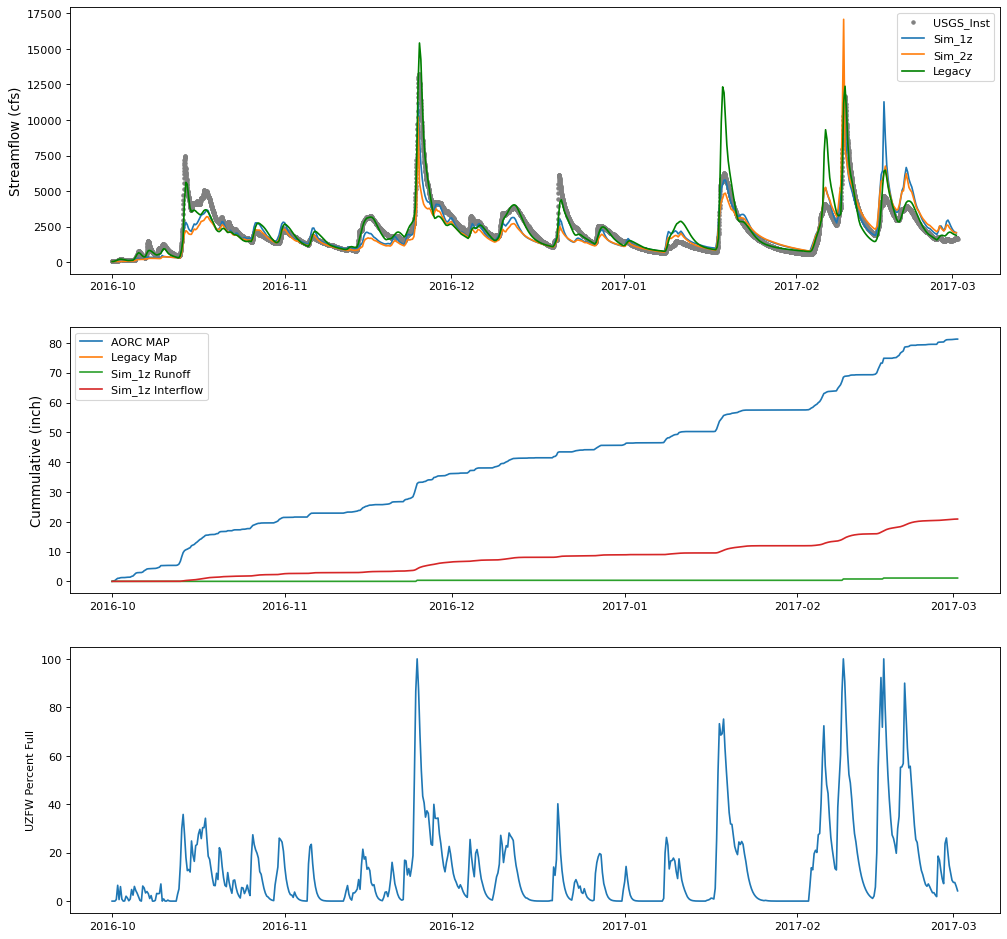

In [226]:
fig, ax = plt.subplots(3,1, dpi= 80, facecolor='w',figsize=(15, 15))

wy=2017
start='Oct 1 ' + str(wy-1)
end='Mar 1 ' + str(wy)
ax[0].scatter(usgs_inst.loc[start:end].index,usgs_inst.loc[start:end,['Inst_Streamflow_cfs']],color='gray',marker='.',label='USGS_Inst')
ax[0].plot(sim_1z.sim.loc[start:end],label='Sim_1z')
ax[0].plot(sim_2z.sim.loc[start:end],label='Sim_2z')
ax[0].plot(legacy_sim.loc[start:end],label='Legacy',color='green')
#fig.suptitle(lid,size=16, y=.95)
ax[0].set_ylabel('Streamflow (cfs)',size=12)
ax[0].legend()


ax[1].plot(sim_1z.sacsnow_states['map_pxadj'].loc[start:end].cumsum().multiply(0.0393701),label='AORC MAP')
#ax[1].plot(sim_1z.sacsnow_states['raim'].loc[start:end].cumsum().multiply(0.0393701),label='Raim')
ax[1].plot(legacy_forcings.loc[start:end,['BEAO3_MAP_PI']].cumsum(),label='Legacy Map')
ax[1].plot(sim_1z.sacsnow_states['ssur'].loc[start:end].multiply(0.0393701).cumsum(),label='Sim_1z Runoff')
ax[1].plot(sim_1z.sacsnow_states['sif'].loc[start:end].multiply(0.0393701).cumsum(),label='Sim_1z Interflow')

ax[1].set_ylabel('Cummulative (inch)',size=12)
ax[1].legend()

ax[2].plot(sim_1z.sacsnow_states['uzfwc'].loc[start:end].divide(sim.pars.loc[sim.pars.name.str.contains('uzfwm')].value.squeeze()).multiply(100))
ax[2].set_ylabel('UZFW Percent Full')

In [6]:
states.keys()

dict_keys(['map_pxadj', 'etd_adj', 'tci', 'aet', 'uztwc', 'uzfwc', 'lztwc', 'lzfsc', 'lzfpc', 'adimc', 'roimp', 'sdro', 'ssur', 'sif', 'bfs', 'bfp', 'swe', 'aesc', 'neghs', 'liqw', 'raim', 'psfall', 'prain', 'sf'])

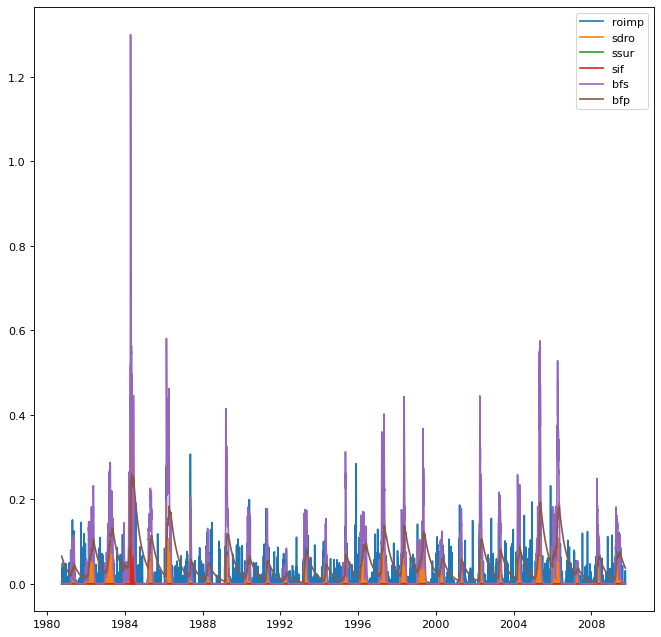

In [11]:
fig, ax = plt.subplots(1,1, dpi= 80, facecolor='w',figsize=(10, 10))

start='Oct 1 1980'
end='Sep 30 2009'

ax.plot(states['roimp'].loc[start:end,'OMCN2-1'],label='roimp')
ax.plot(states['sdro'].loc[start:end,'OMCN2-1'],label='sdro')
ax.plot(states['ssur'].loc[start:end,'OMCN2-1'],label='ssur')
ax.plot(states['sif'].loc[start:end,'OMCN2-1'],label='sif')
ax.plot(states['bfs'].loc[start:end,'OMCN2-1'],label='bfs')
ax.plot(states['bfp'].loc[start:end,'OMCN2-1'],label='bfp')

ax.legend()

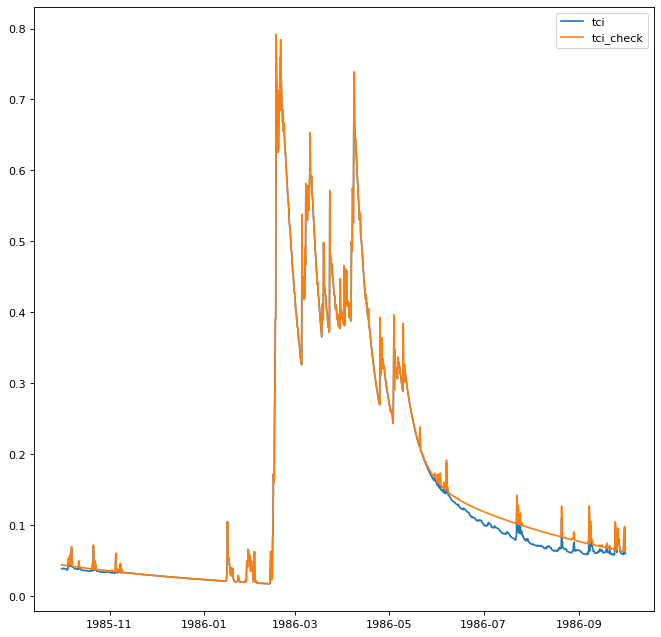

In [14]:
tci_check=states['roimp']+states['sdro']+states['ssur']+states['sif']+states['bfs']+states['bfp']

fig, ax = plt.subplots(1,1, dpi= 80, facecolor='w',figsize=(10, 10))

start='Oct 1 1985'
end='Sep 30 1986'

ax.plot(states['tci'].loc[start:end,'OMCN2-1'],label='tci')
ax.plot(tci_check.loc[start:end,'OMCN2-1'],label='tci_check')

ax.legend()
#diff=states['tci']-tci_check
#diff.plot()

In [39]:
def cyclical_flow(sf):
    sf_cyclical=sf.groupby(sf.index.dayofyear).mean()
    sf_cyclical['Date']=pd.to_datetime(2099, format='%Y') + pd.to_timedelta(sf_cyclical.index - 1, unit='d')
    #Drop the extra day from the leap day
    sf_cyclical=sf_cyclical[:-1]
    sf_cyclical.reset_index(inplace=True)
    sf_cyclical.loc[sf_cyclical.Date>='10/2099',['Date']]=sf_cyclical.loc[sf_cyclical.Date>='10/2099',['Date']]- pd.DateOffset(years=1)
    sf_cyclical.set_index(['Date'],inplace=True)
    sf_cyclical.sort_index(inplace=True)
    sf_cyclical.drop(['index'],axis=1,inplace=True)
    return(sf_cyclical)

In [110]:
sim.p['chanloss']

{'cl_factor': array([1.04712475, 1.49444677, 1.4476256 ]),
 'cl_period_end': array([5., 5., 6.]),
 'cl_period_start': array([4., 5., 6.]),
 'cl_type': array([1.])}

In [3]:
lid='MLBO3_varq'

run_dir='opt_run'
run='results_por_01'
run_dir=os.path.join(folder,'runs',run_dir,'2zone',lid)

forcing, pars, upflow, flow =nwsrfs_prep(run_dir,run)
sim = Model(forcing,pars,upflow,flow)
print(sim.p['chanloss']['cl_factor'])
print(sim.p['chanloss']['cl_period_start'])
print(sim.p['chanloss']['cl_period_end'])

[20.34521909 57.88825821 90.0470802  68.97054055 56.20938964]
[10. 11. 12.  7.  8.]
[10. 11.  6.  7.  9.]


<AxesSubplot:xlabel='Date'>

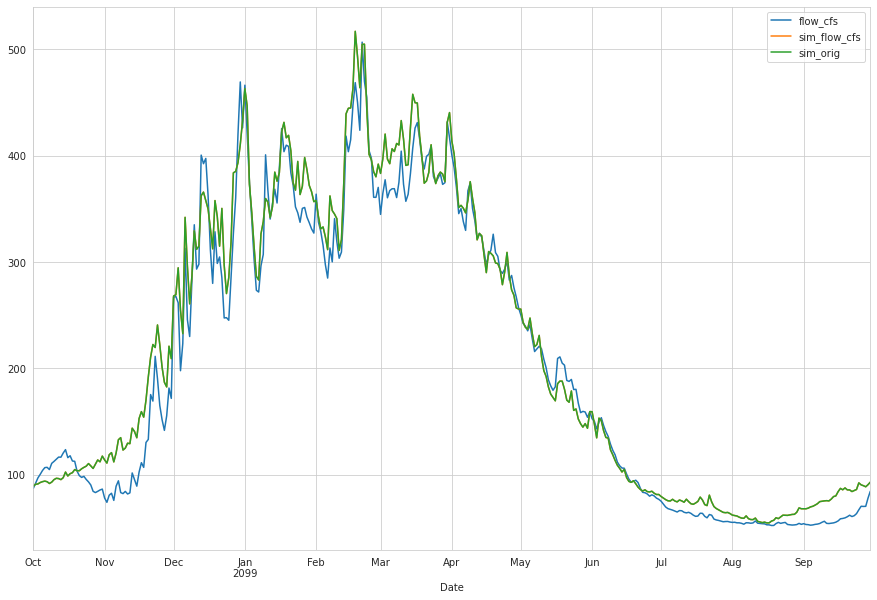

In [469]:
sim = Model(forcing,pars,upflow,flow)
sim_orig=sim.run_all()

#sim.p['chanloss']['cl_factor']=np.array([131.13347576,  90.00090228,  12.02190055,  130])
#sim.p['chanloss']['cl_period_start']=np.array([1.,  7.,  10., 11.])
#sim.p['chanloss']['cl_period_end']=np.array([ 7,  9, 10, 12.])

sf=pd.concat([sim.obs.flow_cfs,sim.run_all().rename('sim_flow_cfs'),sim_orig.rename('sim_orig')],axis=1)
sf_cyclical=cyclical_flow(sf)
sf_cyclical.plot(figsize=(15, 10))

In [31]:
import matplotlib.animation as animation
# Enable interactive plot
%matplotlib notebook

#create fig/axes
fig = plt.figure(figsize=(10, 10),dpi= 80, facecolor='w',edgecolor='k')

gs = fig.add_gridspec(10, 2)

ax1=plt.subplot(gs[:8, :])
ax2=plt.subplot(gs[9, :])

ax1.plot(cyclical_flow(flow.loc[:,['flow_cfs']]),color='grey',lw=1.5,linestyle=':',label='Observed')
ax1.plot(sim_final,color='black',lw=2,label='Final Sim')
line, = ax1.plot(sim_trace_cyclical.iloc[:,0],linestyle='--',color='salmon',label='AC Progression')
title = fig.suptitle(lid,y=.925,fontsize=20)
ax1.legend()

ax2.set_xlim([0,sim_trace_cyclical.columns[-1]])
hline=ax2.axhline(y=0.5, xmin=0, xmax=0,lw=50)
ax2.set_xlabel('Iteration')
ax2.get_yaxis().set_ticks([])


def animate(i):
    line.set_ydata(sim_trace_cyclical.iloc[:,i])  # update the data.
    hline.set_xdata([0,(i*10)/sim_trace_cyclical.columns[-1]])
    return line,hline

hline.set_xdata([0,(250*10)/sim_trace_cyclical.columns[-1]])
ani = animation.FuncAnimation(fig, animate, frames=251,interval=10)

plt.show()

ani.save(lid+".gif")

,flow_cfs,sim_flow_cfs
1979-10-01 00:00:00,50.828604,21.162785
1979-10-01 06:00:00,50.828604,21.162785
1979-10-01 12:00:00,50.828604,40.407238
1979-10-01 18:00:00,50.828604,49.414265
1979-10-02 00:00:00,51.383206,52.595905
...,...,...
2019-09-28 18:00:00,53.048292,96.998490
2019-09-29 00:00:00,60.197396,97.830936
2019-09-29 06:00:00,NaN,94.644672
2019-09-29 12:00:00,NaN,91.864052


In [16]:
store=h5py.File(os.path.join(folder,'data','HDF5_Files','NASW1.h5'), 'r')
keys=get_dataset_keys(store)
precip=hdf_to_df(store, 'Forcing/Zones2/MAP')
store.close
keys

['Forcing/Zones1/MAP',
 'Forcing/Zones1/MAT',
 'Forcing/Zones1/PTPS',
 'Forcing/Zones2/MAP',
 'Forcing/Zones2/MAT',
 'Forcing/Zones2/PTPS',
 'Forcing/Zones3/MAP',
 'Forcing/Zones3/MAT',
 'Forcing/Zones3/PTPS',
 'Streamflow/Daily']

In [13]:
import glob

In [17]:
folder

'/home/gwalters/Repo/nwrfc-auto-calibration'

In [16]:
glob.glob(os.path.join(folder))

[]

In [11]:
autocalb_files=pd.DataFrame(columns=['path','file_name']) 
n=1

for root, dirs, files in os.walk(os.path.join(folder,'runs',run_dir,'2zone',lid)):
    for file in files:
        if '.csv' in file:

            autocalb_files=pd.concat([autocalb_files,
                                      pd.DataFrame({'path':root,
                                                   'file_name':file},index=[n])],axis=0)
            n=n+1
autocalb_files

,path,file_name


In [4]:
pd.Series(self.pars.loc[self.pars.type=='consuse'].zone.unique()).str.split('-').str[-1].values

NameError: name 'self' is not defined

In [13]:
sim.consuse_states['QDIV']

,SFLN2-CU
1979-10-01,13.645367
1979-10-02,11.890620
1979-10-03,12.716908
1979-10-04,13.695210
1979-10-05,13.625055
...,...
2022-09-25,14.421941
2022-09-26,14.481034
2022-09-27,14.373520
2022-09-28,12.819347


In [14]:
lid='SFLN2'

run_dir='opt_run'
run='results_por_01'
run_dir=os.path.join(folder,'runs',run_dir,'2zone',lid)

forcing, pars, upflow, flow =nwsrfs_prep(run_dir,run)
sim = Model(forcing,pars,upflow,flow)
sim.run_all()

1979-10-01 00:00:00    12.264538
1979-10-01 06:00:00    12.264538
1979-10-01 12:00:00    38.156557
1979-10-01 18:00:00    54.747527
1979-10-02 00:00:00    63.753129
                         ...    
2022-09-28 18:00:00    23.841945
2022-09-29 00:00:00    24.042814
2022-09-29 06:00:00    24.119213
2022-09-29 12:00:00    24.144604
2022-09-29 18:00:00    24.122005
Length: 62820, dtype: float64